# Periodic Signal Detection via the adaptive Multitaper Method (aMTM)--Python Version v1.0.2
## 7-17-2024 --> 10-23-2024
### Hector Salinas
#### Tutorial on using this python package's functions to produce an aMTM power spectral density (PSD), model the background noise PSD, and identify discrete periodicities in data series
* Link to the python package `amtm-signaldetect`: https://pypi.org/project/amtm-signaldetect/
* Link to the GitHub: https://github.com/hsalinasGIT/amtm_signaldetect'
* (7-17-2024) Current iteration of the python package has functions which returns the data arrays of the spectral data products. Explicit plotting modules to be implemented in the future
    * current functions: `get_atam_specs`, `get_background_psdfit()`, `get_gamtest_confs`, `get_ftest_confs`, `get_gftest_confpeaks`, `freqtrim_amtm_specs()`
* This algorithm of Periodic Signal Detection is a Python version to the already designed/published IDL procedure 
    * (6-29-2023)Simone's Paper describing his IDL code (Di Matteo 2021, JGR): 
        * https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020JA028748
    * (7-14-2023)The imported multitaper method (MTM) python package ws designed by German Prieto
        * https://github.com/gaprieto/multitaper
        * Their website: https://gaprieto.com/software/
    * (8-5-2024)
        * added option to return spectral dataproducts over full or positive frequency range
    * (10-23-2024)
        * Added option to return custom user-inputted confidence level (for F- or $\gamma$-test) from 5-99%
---
* **Fourier Transform Basics**: 
    * X($f_k) = \int_{0}^{T} x(t)e^{-i2\pi ft} dt$ $\rightarrow$ Discrete $\rightarrow$ X[k] = $\Sigma_{n=0}^{N-1}x[n]e^{-i2\pi(k\Delta f)(n\Delta t)}$ = $\Sigma_{n=0}^{N-1}x[n]e^{-i(2\pi k/N)n}$ 
    * where k,n are integers from 0$\rightarrow$N-1
    * X[k]: Fourier coefficients from periodic sequence x[n]
    * Frquency Axis (based on above physical defintions) of Fourier Transform, $f_k = k\Delta f$
        * Where $\Delta f (or f_{ray}) = 1/T = 1/(N\Delta t)$, is the Sampling (Rayleigh) Frequency and T is the period/window length of the time series (in seconds) 
    * $\Delta$t = time step or sample interval (time between samples)
        * Instrument sampling rate: $\Delta$s = 1/$\Delta$t 
        * N = number of datapoints in time series; also used for number of iterations for FFT summation
    * Nyquist Frequency $f_{nyq}$ = 1/($\Delta t \cdot2$)
---

In [1]:
%matplotlib inline 
#^--plot figures in command line
#The Periodic Signal Detection Python Package--v
from amtm_signaldetect import*  #importing all the aMTM Signal Detection Packages
#Additional packages for general math and plotting--v
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec #nice alternatie way of doing subplots
import numpy as np
import random

In [2]:
help(get_amtm_specs)

Help on function get_amtm_specs in module amtm_signaldetect.aMTMSignalDetect:

get_amtm_specs(xdata, tdata, achFull, NW, Ktpr=None)
    Using Prieto's MTM python package: Compute/return the aMTM PSD, corresponding frequencies, 
    half-degrees of freedom, and F-test arrays over the positive frequency range [0, fny]
    
    :Params:
        xdata: data series to be Fourier transformed (ie. X(t), Y(t), etc)
        tdata: corresponding "time" series of above data series
        achFull: (str) option to return spectral products over full or positive frequency spectrum
        NW: (>1, an integer) frequency resolution bandwidth
        Ktpr: (optional, int) number of tapers to use 
    :Returns:
        afFreq_pf: corresponding Fourier frequencies defined over positive frequency (pf) range
        afSk_pf: aMTM PSD estimate defined of positive frequency range
        afAlphak_pf: half-degrees of freedom defined over positive frequency range
        afFtest_pf: Harmonic F-test defined ove

## 1) Simple Example of Returning aMTM Spectral Data Products
* `get_amtm_specs()`**uses Prieto's MTM package and returns an aMTM power spectral density (PSD) ($S_k$), the corresponding Fourier frequencies ($f_k$), the half-degrees of freedom ($α_k$), and the Harmonic F-test ($F_k$) over the positive frequency range [0, $f_{ny}$].** 
---
* The below test cell produces/plots the aMTM PSD of a time series of a pure sine wave embedded in white noise. We call simply call our function as:
    * `[afFreqk, afSk, afAlphak, afFtestk] = get_amtm_specs(afX, afT, achFull, nw_in)`
        * `achFull = 'full'` returns spectral dataproducts over the full frequency range, and all other str options defaults to the positive frequency spectrum

Rayleigh frequency is 0.2 and N =  2500
Nyquist frequency =  250.0 , dt =  0.002 , T =  4.998 , N =  2500
Creating Prieto MTSPEC class for Data(NW = 3, Ktpr = 5)


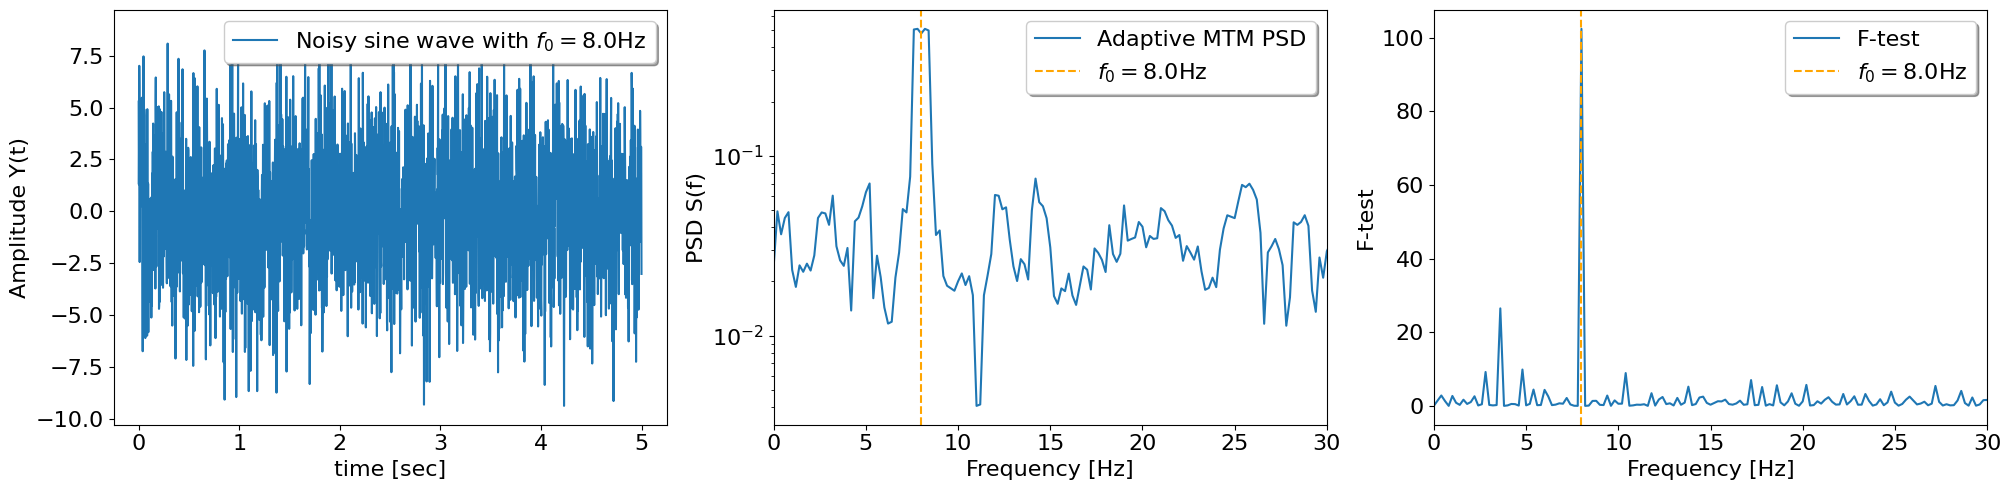

In [3]:
fSine = lambda A,f,t: A*np.sin(2*np.pi*f*t) #Defining anonymous functions (Python's version of explicit math functions)


def test_get_amtm():
    """Test get_amtm_specs"""
    #----------Generating Time Series---------------v
     #-OG Data params-
    ds = 500 #sampling rate, equivalent to dt = 0.002s
    dt = 1/ds
    afT = np.arange(0, 5, dt) #5 second interval with 1000 dtps (N = T*ds or T = N*dt)
    N = len(afT)
    f_ray = 1/(N*dt)
    f_nyq = 1/(2*dt)
    print('Rayleigh frequency is', f_ray, 'and N = ', N)
    #-Defining various time series
    freq1 = 8.0
    OG_sine = fSine(1,freq1,afT) #pure sine wave with f = freq1 Hz
    np.random.seed(0) #define seed so we get consistent random values
    mu, sigma = 0, 3 # standard normal distribution (Gaussian with mu = 0 and sigma = 1)
    afWhite = np.random.normal(mu, sigma, len(afT)) #making white noise based on normal (Gaussian) distribution
    afX = OG_sine + afWhite
    #-----------------------------------------------
    #---------Producing aMTM Spectral Dataproducts from data series---------v
    nw_in = 3 #Ktpr = 5
    achSpect = ''
    [afFreq_mtm, afSk_mtm, afAlpha_mtm, Ftest_mtm] = get_amtm_specs(afX, afT, achSpect,nw_in) #extract Pietro aMTM PSD and dpss
    #-----------------------------------------------------------------------
    #--Plotting aMTM Spectral Dataproducts--------------------------v
    #-Using GridSpec to plot the various time series and corresponding FFTs
    fig = plt.figure(figsize = (20,5))
    gs = GridSpec(1, 3, figure=fig) # (Row x Col) plot
    ax1 = fig.add_subplot(gs[0, 0]) 
    ax2 = fig.add_subplot(gs[0, 1]) 
    ax3 = fig.add_subplot(gs[0, 2]) 
    fsize = 16 #fontsize of axis labels/ticks
    legsize = 18 #legend fontsize
    tsize = 12 #titlesize    
        #-Plotting Time Series
    ax1.plot(afT, afX, label = r'Noisy sine wave with $f_0 = %0.1f$Hz'%(freq1))
    ax1.legend(loc = 'upper right', shadow = True, prop={'size': legsize-2})
    ax1.set_ylabel('Amplitude Y(t)', fontsize = fsize)
    ax1.set_xlabel('time [sec]', fontsize = fsize)
        #-Plotting PSD
    ax2.semilogy(afFreq_mtm, afSk_mtm, label = 'Adaptive MTM PSD')
    ax2.axvline(freq1, color = 'orange', ls = '--', label = r'$f_0 = %0.1f$Hz'%(freq1))
    ax2.set_ylabel('PSD S(f)', fontsize = fsize)
    ax2.set_xlabel('Frequency [Hz]', fontsize = fsize)
    ax2.set_xlim(0, 30)
        #-Plotting Ftest
    ax3.plot(afFreq_mtm, Ftest_mtm, label = 'F-test')
    ax3.axvline(freq1, color = 'orange', ls = '--', label = r'$f_0 = %0.1f$Hz'%(freq1))
    ax3.set_xlabel(r'Frequency [Hz]', fontsize = fsize)
    ax3.set_ylabel('F-test', fontsize = fsize)
    ax3.set_xlim(0, 30)
    ax1.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax2.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax3.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
        #-Setting tick axes labelsize
    ax1.tick_params(axis='both', labelsize=fsize)
    ax2.tick_params(axis='both', labelsize=fsize) 
    ax3.tick_params(axis='both', labelsize=fsize) 
    plt.tight_layout()
    #plt.savefig('PyHCtechdemo_simpleFtest_example.png', bbox_inches='tight', facecolor = 'w')
    return;
test_get_amtm()

In [4]:
help(get_background_psdfit)

Help on function get_background_psdfit in module amtm_signaldetect.aMTMSignalDetect:

get_background_psdfit(tdata, afFreq, afSpec, afAlpha, achFit, NW, Frange=None)
    Using aMTM spectrum inputs, use the maximum log-likelihood approach to fit the noisy spectra 
    background with a Bending Power Law (BPL), Power Law (PL), or analytical White (WHT) Noise solution
    
    :Params:
        tdata: (ndarray) corresponding time array for data series
        afFreq: (ndarray) positive fourier frequency array
        afSpec: (ndarray) aMTM PSD array
        afAlpha: (ndarray) half-degrees of freedom
        achFit: (str) 'WHT', 'BPL', or 'PL' background fit option
        NW: (>1, int) frequency resolution bandwidth
        Frange: (optional, ndarray) frequency range [flow, fhigh] to perform background fit over
    
    :Returns:
        Fj_in: (ndarray) corresponding Fourier frequency array for background-fitted PSD
        Bj_best: (ndarray) background-fitted PSD
        fit_best: (ndarra

## 2) Simple Example of Returning the Background-Modelled aMTM PSD
* `get_background_psdfit()`:**With the above spectral data products ($S_k, \alpha_k, f_k$), we model the background PSD by using the 'maximum likelihood method' to apply either an analytical white noise (WHT), power law (PL), or bending power law (BPL) fit over a user-chosen frequency range**
    * **Power Law (PL)** for PSD Background: B(f) = $B_j = cf_j^{-\beta}$
    * **White Noise (WHT)** is PL with $\beta$ = 0: B(f) = scalar constant c
        * Has analytical solution where $c = \Sigma_k\alpha_k S_k/(\Sigma_k\alpha_k)$
    * **Bending Power Law (BPL)** for PSD Background:
        * B(f) = $B_j = cf_j^{-\beta}/(1 + (f_j/f_b)^{\gamma - \beta})$ 
            * 4 parameters: constant factor "c", "$\beta$" and "$\gamma$" are the spectal indices which respectively dominate the frequency intervals above and below the frequency break "$f_b$" at which the model bends
---
* Using the same noisy sine wave from (1), the below test cell produces/plots the background noise-modelled PSD of the aMTM PSD produced by `get_amtm_specs`. We call simply call our function as:
    * `[afFreqk_bkg, afBk, FITparams] = get_background_psdfit(afT, afFreqk, afSk, afAlphak, achFIT,nw_in, frange_in)`

Rayleigh frequency is 0.2 and N =  2500
Nyquist frequency =  250.0 , dt =  0.002 , T =  4.998 , N =  2500
Creating Prieto MTSPEC class for Data(NW = 3, Ktpr = 5)
	Default Fitting Frequency Range: 1.2 to 248.8 Hz
	Power Law Fitting over (default) frequency range: [1.20, 248.80] Hz
	Using SLSQP optimize method--v
	Optimized PL Params for [c, beta]: [0.05738344 0.1019078 ]


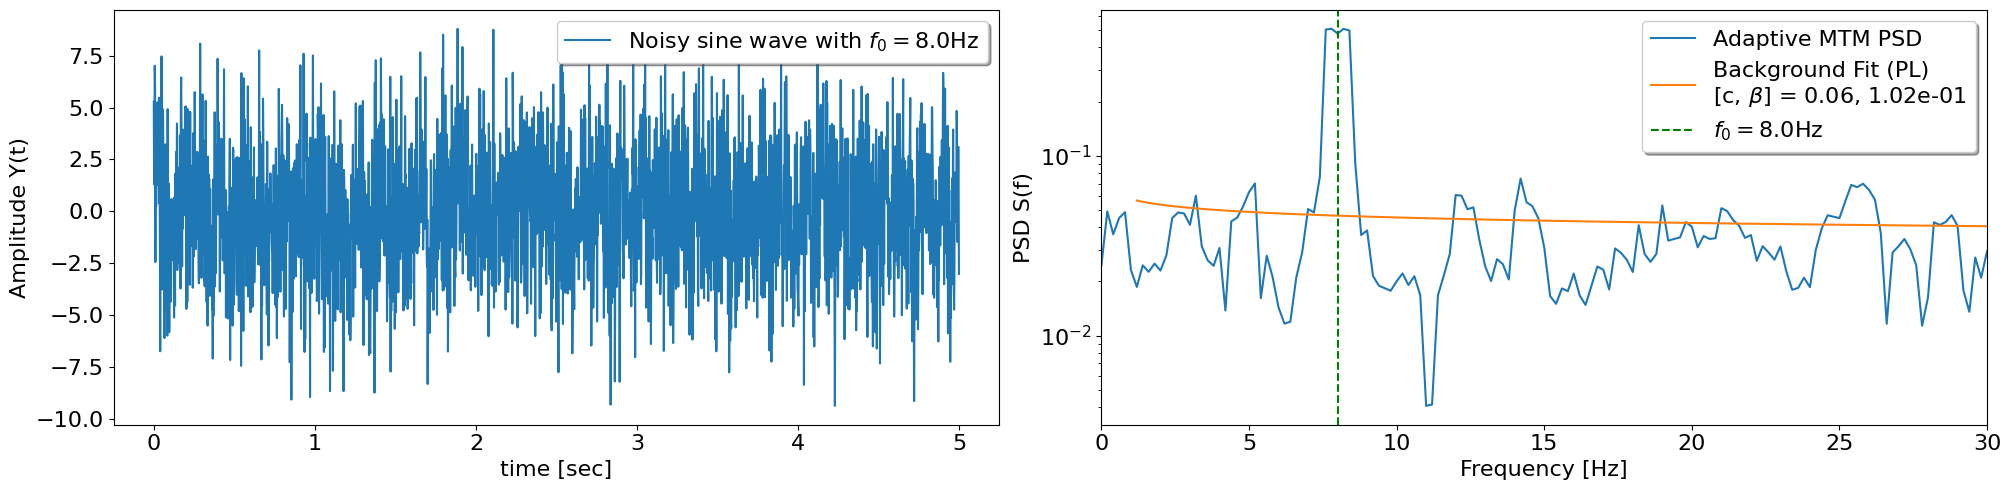

In [5]:
def test_background_fit_():
    """Test get_pietro_spec_params and fit_spectra_background"""
    #----------Generating Time Series---------------v
    #-OG Data params-
    ds = 500 #sampling rate, equivalent to dt = 0.002s
    dt = 1/ds
    afT = np.arange(0, 5, dt) #5 second interval with 1000 dtps (N = T*ds or T = N*dt)
    N = len(afT)
    f_ray = 1/(N*dt)
    f_nyq = 1/(2*dt)
    print('Rayleigh frequency is', f_ray, 'and N = ', N)
    #-Defining various time series
    freq1 = 8.0
    OG_sine = fSine(1,freq1,afT) #pure sine wave with f = freq1 Hz
    np.random.seed(0) #define seed so we get consistent random values
    mu, sigma = 0, 3 # standard normal distribution (Gaussian with mu = 0 and sigma = 1)
    afWhite = np.random.normal(mu, sigma, len(afT)) #making white noise based on normal (Gaussian) distribution
    afX = OG_sine + afWhite
    #-----------------------------------------------
    #---------Producing aMTM Spectral Dataproducts from data series---------v
    nw_in = 3 #Ktpr = 5
    achSpect = ''
    [afFreq_mtm, afSk_mtm, afAlpha_mtm, Ftest_mtm] = get_amtm_specs(afX, afT, achSpect,nw_in) #extract Pietro aMTM PSD and dpss
    #-----------------------------------------------------------------------
    #---------Extract Background-Modelled PSD--------------v
    achFIT = 'PL' #background fit model
    frange_in = None #frange, don't need to explicitly define
    [afFk_bkg, afBk, FITparams] = get_background_psdfit(afT, afFreq_mtm, afSk_mtm, afAlpha_mtm, achFIT,nw_in, frange_in) 
    if achFIT == 'BPL':
        achPSDfit = r'[c, $\beta, \gamma, f_b$] = %0.2f, %0.2f, %0.2f, %0.2f'%(FITparams[0], FITparams[1], FITparams[2], FITparams[3])
    elif achFIT == 'PL':
        achPSDfit = r'[c, $\beta$] = %0.2f, %0.2e'%(FITparams[0], FITparams[1])
    else: #default WHT solution
        achPSDfit = '[c] = %0.2f'%(FITparams)
    #----------------------------------------------
    #--Plotting time series, aMTM PSD, and background noise-modelled PSDS--------------------------v
    #-Using GridSpec to plot the various time series and corresponding FFTs
    fig = plt.figure(figsize = (20,5))
    gs = GridSpec(1, 2, figure=fig) # (Row x Col) plot
    ax1 = fig.add_subplot(gs[0, 0]) 
    ax2 = fig.add_subplot(gs[0, 1]) 
    fsize = 16 #fontsize of axis labels/ticks
    legsize = 18 #legend fontsize
    tsize = 12 #titlesize    
        #-Plotting Time Series
    ax1.plot(afT, afX, label = r'Noisy sine wave with $f_0 = %0.1f$Hz'%(freq1))
    ax1.legend(loc = 'upper right', shadow = True, prop={'size': legsize-2})
    ax1.set_ylabel('Amplitude Y(t)', fontsize = fsize)
    ax1.set_xlabel('time [sec]', fontsize = fsize)
        #-Plotting PSD with background fit
    ax2.semilogy(afFreq_mtm, afSk_mtm, label = 'Adaptive MTM PSD')
    ax2.semilogy(afFk_bkg, afBk, label = 'Background Fit (%s)\n%s'%(achFIT, achPSDfit))
    ax2.axvline(freq1, color = 'green', ls = '--', label = r'$f_0 = %0.1f$Hz'%(freq1))
    ax2.set_ylabel('PSD S(f)', fontsize = fsize)
    ax2.set_xlabel('Frequency [Hz]', fontsize = fsize)
    ax2.set_xlim(0, 30)
    ax1.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax2.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
        #-Setting tick axes labelsize
    ax1.tick_params(axis='both', labelsize=fsize)
    ax2.tick_params(axis='both', labelsize=fsize) 
    plt.tight_layout()
    return;

test_background_fit_()

In [6]:
help(get_gamtest_confs)

Help on function get_gamtest_confs in module amtm_signaldetect.aMTMSignalDetect:

get_gamtest_confs(tdata, afFreq, afSpec, afAlpha, afBkg, NW, Frange=None, INconf=None)
    Compute/return the (90,95,99)% confidence levels of the gamma-test(aMTM PSD/Background Fit) 
    using the spectral dataproducts (fk, Sk, Bk, alphak) (NEW way of Compute/Return Confidence Level for the aMTM PSD)
    
     :Params:
        tdata: (ndarray) corresponding time array for data series
        afFreq: (ndarray) positive fourier frequency array
        afSpec: (ndarray) aMTM PSD array
        afAlpha: (ndarray) half-degrees of freedom
        afBkg: (nedarray) Background-fitted PSD
        NW: (>1, int) frequency resolution bandwidth
        Frange: (optional, ndarray) frequency range [flow, fhigh] to perform background fit over
        INconf: (optional, float) custom user-inputted confidence level from 0.05-0.98
    
    :Returns:
        gammaj: (ndarray) gamma-test array 
        afZ[ind90[0,0]]:(float)

In [7]:
def get_ar1_rednoise(fLength, afW):
    """Generate Red Noise using AR1: x[t+1] = rho*x[t] + w[n], where w[n] = white noise"""
    #Initialize red noise array and define afRed[0]
    afRed = np.empty(fLength) 
    afRed[0] = afW[0]
    #Generate AR(1) red noise array
    rho = 0.9
    for i in range(fLength-1):
        afRed[i+1] = rho*afRed[i] + afW[i]
    return(afRed);

def test_red_noise():
    """Testing AR(1) red noise comparison with white noise"""
    afTime = np.arange(0,512,1) #time array from 0-511seconds, dt = 1
    np.random.seed(2) #define seed so we get consistent random values
    mu, sigma = 0, 1 # standard normal distribution (Gaussian with mu = 0 and sigma = 1)
    afWhite = np.random.normal(mu, sigma, len(afTime)) #making white noise based on normal (Gaussian) distribution
    afRed = get_ar1_rednoise(len(afTime), afWhite) #return AR(1) red noise
    #--Define aMTM PSDs of red and white noise time series
    achSpect = ''
    [afFk_w, afSk_w, afAlphak_w, afFtest_w] = get_amtm_specs(afWhite, afTime, achSpect, 2) #NW = 3, Ktpr = 5
    [afFk_r, afSk_r, afAlphak_r, afFtest_r] = get_amtm_specs(afRed, afTime, achSpect, 2) #NW = 3, Ktpr = 5
    #--Plot Data
    fig, ax = plt.subplots(2, figsize = (10,10))
    ax[0].plot(afSk_w, label = 'White Noise')
    ax[1].plot(afSk_r, label = 'Red Noise')
    ax[0].legend(loc = 'best')
    ax[1].legend(loc = 'best')
    plt.tight_layout()
    return;

#test_red_noise()

In [8]:
help(get_ftest_confs)

Help on function get_ftest_confs in module amtm_signaldetect.aMTMSignalDetect:

get_ftest_confs(Ktprs, tdata, afFreq, afFtest, NW, Frange, INconf=None)
    Compute/return Ftest confidence level(s) using F-distribution percent point function
      :Params:
        Ktprs: (int) number of tprs to use
        tdata: (ndarray) corresponding time array for data series
        afFreq: (ndarray) positive fourier frequency array
        afFtest: (ndarray) Ftest array that corresponds to background-fitted PSD
        NW: (>1, int) frequency resolution bandwidth
        Frange: (optional, ndarray) frequency range [flow, fhigh] to perform background fit over
        INconf: (optional, float) custom user-inputted confidence level from 0.05-0.98
    
        
    :Returns:
        Fcrit90: (float) 90% confidence level Ftest value
        Fcrit95: (float) 95% confidence level Ftest value
        Fcrit99: (float) 99% confidence level Ftest value
        Fcrit50: (float) 50% (default) or custom user-in

In [9]:
help(get_gftest_confpeaks)

Help on function get_gftest_confpeaks in module amtm_signaldetect.aMTMSignalDetect:

get_gftest_confpeaks(afFreq, afGam, af_Ftest, Fcrit, Gcrit, NW, tdata)
    Find +[user-inputted]% conf peaks of Ftest, Gamma-statistic, and overlapping peaks within 1 bandwidth (NW*fray) of each other
    
    :Params:
        afFreq: (ndarray) fourier frequency array that corresponds to background-fitted PSD
        afGam: (ndarray) gamma-test array
        af_Ftest: (ndarray) Ftest array that corresponds to background-fitted PSD
        Fcrit: (float) Ftest [input]% confidence level value
        Gcrit: (float) gamma-test [input]% confidence level value
    
    :Returns:
        Fpeaks: (ndarry) array of indices for Ftest peaks above Fcrit value
        Gpeaks: (ndarry) array of indices for gamma-test peaks above Gcrit value
        np.unique(afGtrue): (ndarray) array of interescting fourier frequency values where F- and gam-test peaks occur (with respect to Gamma-test)
        np.unique(afFtrue): (

# 3) Simple Example which Calculates the confidence thresholds of the $\gamma$-test and F-test to determine if a PSD enhancement is a discrete periodic signal
* `get_gamtest_confs` and `get_ftest_confs`:**After first ensuring that our spectral products ($S_k,f_k,α_k,F_k$) matches the frequency-range of our background modelled PSD ($B_k$). We compute of the confidence levels (90%, 95%, 99%) of both the $\gamma$-test ($\gamma_k = S_k/B_k$) and Harmonic F-test to explicitly determine if spectral peak(s) are statistically significant (passes both dual-confidence levels)**
---
* After generating the aMTM (1) and background-modelled (2) PSD using `get_amtm_specs` and `get_background_psdfit()`, the below test cell computes the respective confidence levels of the $\gamma$-test and Ftest. After which, it uses `get_gftest_confpeaks` to determine where the Ftest and $\gamma$-test have intersecting and individual peaks above their respective confidence levels. We simply call our functions as:
    * `[Fcrit90, Fcrit95, Fcrit99, Fcrit50, afFtest_trim] = get_ftest_confs(Ktprs, afT, afFreqk, afFtestk, nw_in, Frange, INconf)`
    * `[afGamk, Gcrit90, Gcrit95, Gcrit99, Gcrit50] = get_gamtest_confs(afT, afFreqk, afSk, afAlphak, afBk, nw_in, Frange, INconf)`   
    * `[Fpeaks, Gpeaks, FG_pk, FG_pkfreq] = get_gftest_confpeaks(afFreqk_bkg, afGamk, afFtest_trim, Fcrit99, Gcrit99)`
        * To enter a custom confidence level, just enter a float (between 0.05 and 0.98) value into the `INconf` input.
    

Nyquist frequency =  0.5 , dt =  1 , T =  511 , N =  512
Creating Prieto MTSPEC class for Data(NW = 3, Ktpr = 5)
	Default Fitting Frequency Range: 0.0 to 0.5 Hz
	Power Law Fitting over (default) frequency range: [0.01, 0.49] Hz
	Using SLSQP optimize method--v
	Optimized PL Params for [c, beta]: [0.17986762 1.58989376]
	Returning (user-inputted) 78.0% F-test confidence level
	Returning (cuser-inputted) 78.0% gam-test confidence level

**Finding overlapping FG-peaks within 1 bandwidth (1*NW*fray = 0.006Hz)
New NWfray-bw intersection Gpeak freqs: [0.12109375 0.125      0.12890625 0.30664062 0.3125    ]
New NWfray-bw intersection Fpeak freqs: [0.125      0.31054688]
Intersecting index locations: [ 58 153] [0.125      0.31054688]
F99peaks freqs:
 [0.08398438 0.125      0.25195312 0.31054688]
G99peaks freqs:
 [0.12109375 0.125      0.12890625 0.30664062 0.3125     0.484375  ]


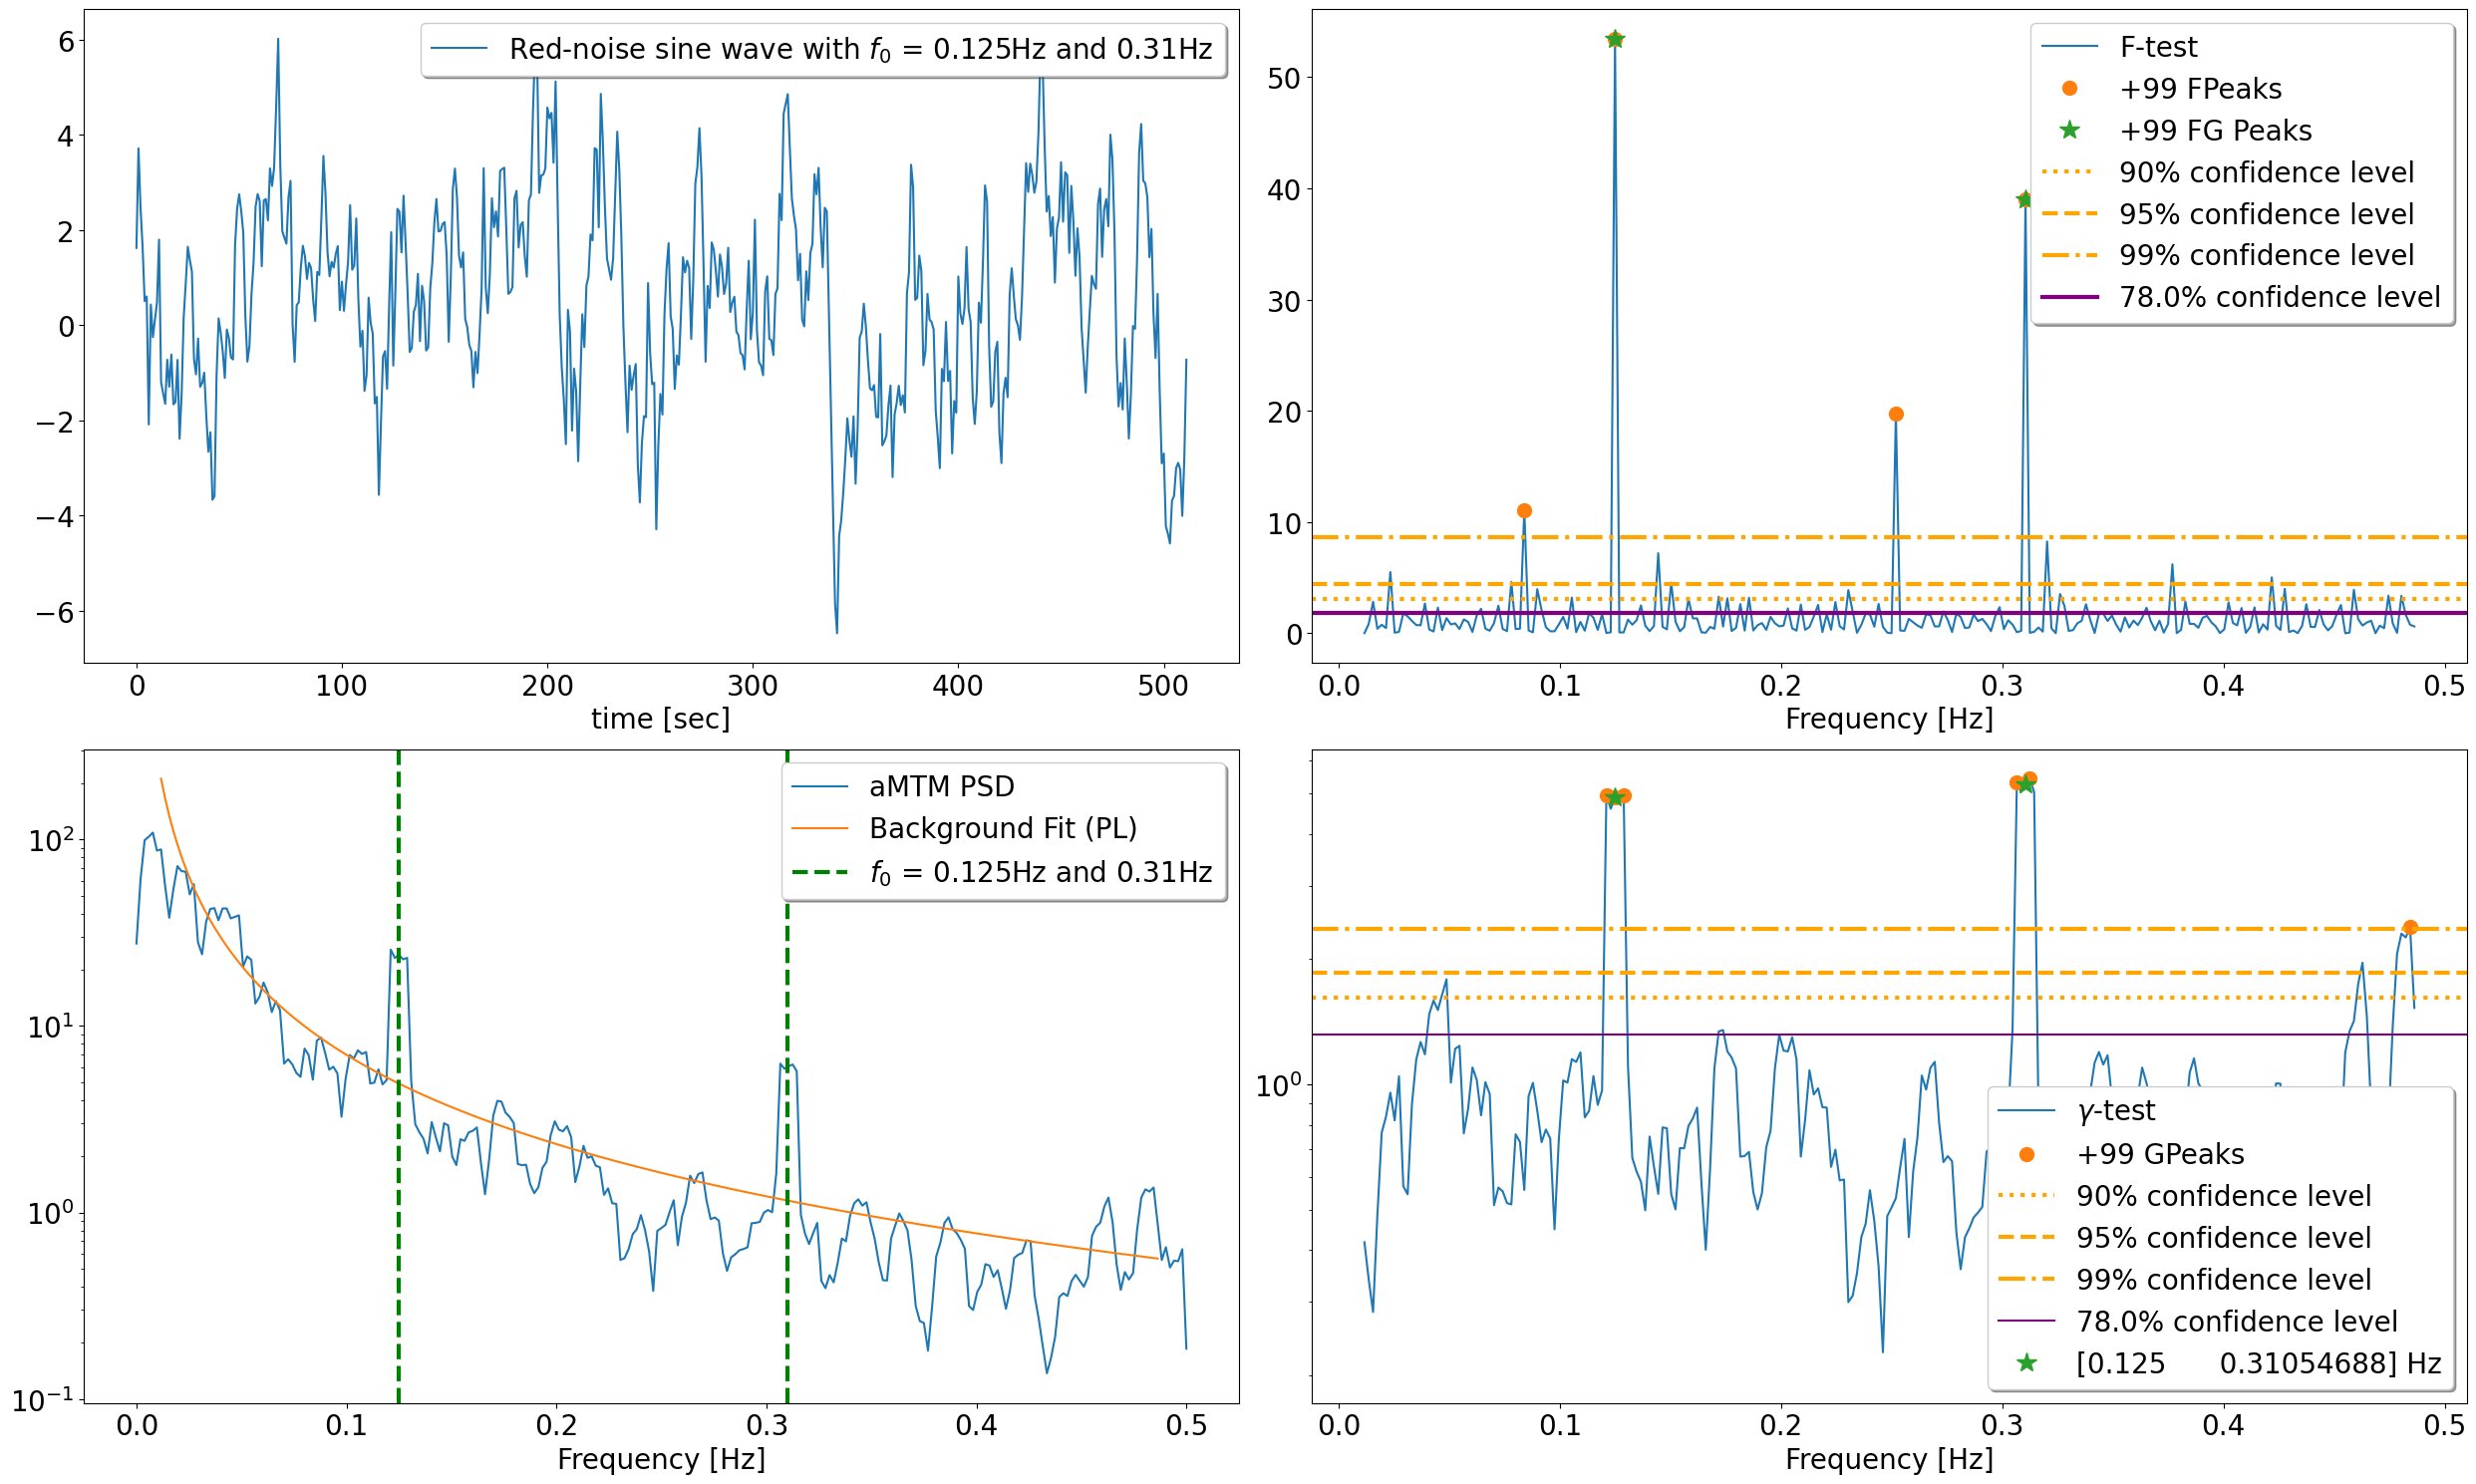

In [14]:
def test_mtm_confs():
    """Testing get_ftest_confs, get_gamtest_confs and get_gftest_conf peaks"""
    #----------Generating Time Series---------------v    
    afTime = np.arange(0,512,1) #time array from 0-511seconds, dt = 1
    freq1 = 1/8
    freq2 = 0.31
    #OG_sine =  0.5*np.sin(2*np.pi*afTime/8) #IDL: pure sine wave with noise(512 length, std = 1)
    OG_sine = fSine(0.5,freq1,afTime) #pure sine wave with A = 0.5 and f = 1/8 Hz (cycles/sec)
    OG_sine2 = fSine(0.3,freq2,afTime) #pure sine wave with A = 0.3 and f = 0.25 Hz (cycles/sec)

    np.random.seed(1) #define seed so we get consistent random values
    mu, sigma = 0, 1 # standard normal distribution (Gaussian with mu = 0 and sigma = 1)
    afWhite = np.random.normal(mu, sigma, len(afTime)) #making white noise based on normal (Gaussian) distribution
    afRed = get_ar1_rednoise(len(afTime), afWhite) #return AR(1) red noise
    afX = OG_sine + afRed + OG_sine2
    #-----------------------------------------------    
    #---------Produce aMTM Spectral Dataproducts and Background PSD fit from data series---------v
    achFit = 'PL'
    nw_in = 3
    ktpr_in = None
    achSpect = ''
    [afFk, afSk, afAlphak, afFtest] = get_amtm_specs(afX, afTime, achSpect, nw_in) #NW = 3, Ktpr = 5
    [afFk_bkg, afBk, FITparams] = get_background_psdfit(afTime,afFk, afSk, afAlphak, achFit, nw_in) #Extract Spectra Background Fit
    #------------------------------------------------------------
    #---Extracting F/Gam-test confidence levels and peaks above confidenve levels---v
    afINconf = 0.78  #custom conf levels
    [Fcrit90, Fcrit95, Fcrit99, Fcrit50, Ftest_in] = get_ftest_confs(2*nw_in-1, afTime, afFk, afFtest, nw_in, Frange = None,INconf = afINconf)
    [afGamk, Gcrit90, Gcrit95, Gcrit99, Gcrit50] = get_gamtest_confs(afTime, afFk, afSk, afAlphak, afBk, nw_in, INconf = afINconf)    
    [Fpeaks, Gpeaks, Gpkfreq_intr, Fpkfreq_intr, FGpk_ind] = get_gftest_confpeaks(afFk_bkg, afGamk, Ftest_in, Fcrit99, Gcrit99, nw_in, afTime)
    #print('\n**New NWfray intersection Gpeak freqs:', nGpkfreq_intr) 
    #print('New NWfray intersection Fpeak freqs:', nFpkfreq_intr)
    #'''
    print('F99peaks freqs:\n', afFk_bkg[Fpeaks])
    print('G99peaks freqs:\n', afFk_bkg[Gpeaks])
    achLabFGpks = '%s Hz'%(Fpkfreq_intr)
    
    #''';    
    #---------------------------------------------
    #--Plotting time series, aMTM PSD with background fit, F-test, and gamma-test--------------------------v
    #-Using GridSpec to plot the various time series and corresponding FFTs
    fig = plt.figure(figsize = (25,15))
    gs = GridSpec(2, 2, figure=fig) # (Row x Col) plot
    ax1 = fig.add_subplot(gs[0, 0]) #time series
    ax2 = fig.add_subplot(gs[1, 0]) #aMTM PSD with background fit
    ax3 = fig.add_subplot(gs[0, 1]) #F-test with conf levels
    ax4 = fig.add_subplot(gs[1, 1]) #gamma-test with confidence levels
    fsize = 20 #fontsize of axis labels/ticks
    legsize = 22 #legend fontsize
    tsize = 20 #titlesize
    f_lw = 3
        #-Plotting Time Series
    ax1.plot(afTime, afX, label = r'Red-noise sine wave with $f_0$ = %0.3fHz and %0.2fHz'%(freq1, freq2))
    ax1.legend(loc = 'upper right', shadow = True, prop={'size': legsize-2})
    #ax1.set_ylabel('Amplitude Y(t)', fontsize = fsize)
    ax1.set_xlabel('time [sec]', fontsize = fsize)
        #-Plotting PSD with background fit
    ax2.semilogy(afFk, afSk, label = 'aMTM PSD')
    ax2.semilogy(afFk_bkg, afBk, label = 'Background Fit (%s)'%(achFit))#, achPSDfit))
    ax2.axvline(freq1, color = 'green', ls = '--', lw = f_lw, label = r'$f_0$ = %0.3fHz and %0.2fHz'%(freq1, freq2))
    ax2.axvline(freq2, color = 'green', ls = '--', lw = f_lw)

    #ax2.set_ylabel('PSD S(f)', fontsize = fsize)
    ax2.set_xlabel('Frequency [Hz]', fontsize = fsize)
        #-Plotting F-test with conf levels
    ax3.plot(afFk_bkg, Ftest_in, label = 'F-test')
    ax3.plot(afFk_bkg[Fpeaks], Ftest_in[Fpeaks], 'o', ms = 10, label = '+99 FPeaks')
    ax3.plot(afFk_bkg[FGpk_ind], Ftest_in[FGpk_ind], '*', ms = 15, label = '+99 FG Peaks')
    ax3.axhline(y = Fcrit90,linestyle = 'dotted',lw = f_lw, color = 'orange', label = '90% confidence level')
    ax3.axhline(y = Fcrit95,linestyle = 'dashed',lw = f_lw, color = 'orange', label = '95% confidence level')
    ax3.axhline(y = Fcrit99,linestyle = 'dashdot',lw = f_lw, color = 'orange', label = '99% confidence level')
    ax3.axhline(y = Fcrit50,linestyle = '-',lw = f_lw, color = 'purple', label = '%s%% confidence level'%(100*afINconf))

    ax3.set_xlabel('Frequency [Hz]', fontsize = fsize)
        #-Plotting Gamma-test (aka, amplitude- or A-test) with conf levels
    ax4.semilogy(afFk_bkg, afGamk, label = r'$\gamma$-test')
    ax4.semilogy(afFk_bkg[Gpeaks], afGamk[Gpeaks], 'o', ms = 10, label = '+99 GPeaks')
    ax4.axhline(y = Gcrit90,linestyle = 'dotted',lw = f_lw, color = 'orange', label = '90% confidence level')
    ax4.axhline(y = Gcrit95,linestyle = 'dashed',lw = f_lw, color = 'orange', label = '95% confidence level')
    ax4.axhline(y = Gcrit99,linestyle = 'dashdot',lw = f_lw, color = 'orange', label = '99% confidence level')
    ax4.axhline(y = Gcrit50,linestyle = '-', color = 'purple', label = '%s%% confidence level'%(100*afINconf))
    ax4.semilogy(afFk_bkg[FGpk_ind], afGamk[FGpk_ind], '*', ms = 15, label = '%s'%(achLabFGpks))
    ax4.set_xlabel('Frequency [Hz]', fontsize = fsize)
        #-Legend parameters
    ax1.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax2.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax3.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax4.legend(loc = 'lower right', shadow = True,prop={'size': legsize-2})
        #-Setting tick axes labelsize
    ax1.tick_params(axis='both', labelsize=fsize)
    ax2.tick_params(axis='both', labelsize=fsize) 
    ax3.tick_params(axis='both', labelsize=fsize) 
    ax4.tick_params(axis='both', labelsize=fsize) 
    plt.tight_layout()
    #fig.savefig('testdirect.png', facecolor = 'w')
    #plt.savefig('jgrTech_dualconftest_BPLfit_redAR1noise_example.png', bbox_inches='tight', facecolor = 'w')
    return;
test_mtm_confs()

In [11]:
####-(Work done as of 10-6-2024)
def NEWget_gftest_confpeaks(afFreq, afGam, af_Ftest, Fcrit, Gcrit, NW, tdata):
    """Find +[user-inputted]% conf peaks of Ftest, Gamma-statistic, and overlapping peaks within 1 bandwidth (NW*fray) of each other
    
    :Params:
        afFreq: (ndarray) fourier frequency array that corresponds to background-fitted PSD
        afGam: (ndarray) gamma-test array
        af_Ftest: (ndarray) Ftest array that corresponds to background-fitted PSD
        Fcrit: (float) Ftest [input]% confidence level value
        Gcrit: (float) gamma-test [input]% confidence level value
    
    :Returns:
        Fpeaks: (ndarry) array of indices for Ftest peaks above Fcrit value
        Gpeaks: (ndarry) array of indices for gamma-test peaks above Gcrit value
        np.unique(afGtrue): (ndarray) array of interescting fourier frequency values where F- and gam-test peaks occur (with respect to Gamma-test)
        np.unique(afFtrue): (ndarray) array of interescting fourier frequency values where F- and gam-test peaks occur (with respect to F-test)
        FGpk_ind: (ndarray) corresponding array of indices , where both F-test and gam-test have peaks above their confidence levels (recall they share the same Fourier freq axis)
    """
    [dt, N, df, F_nyq] = get_tseries_params(tdata) #return dt, N, fray, fnyq
    """find_peaks gets angry about accepting only 1D arrays and afGam/af_Ftest are 1D arrays within an array. 
    So I gotta index into them to avoid the errors"""
    #Find peaks above [user-inputted]% conf threshold
    Gpeaks, _ = find_peaks(afGam, height = Gcrit) #find indices where Gtest has peaks above conf threshol
    Fpeaks, _ = find_peaks(af_Ftest, height = Fcrit)
    freq_fpks = afFreq[Fpeaks] #defining corrsponding frequency array for Fpeaks
    freq_gpks = afFreq[Gpeaks] #define corresponding frequency array for Gpeaks
    '''
    print('Gpeaks indices:', Gpeaks)
    print('Gpeaks freqs:\n', afFreq[Gpeaks])
    print('Fpeaks indices:', Fpeaks)
    print('Fpeaks freqs:\n', afFreq[Fpeaks])
    freq_isect = np.intersect1d(freq_fpks, freq_gpks) #returns which frequency element values and indices intersect
    FG_pk = np.intersect1d(Fpeaks, Gpeaks) #returns element value (which would be a peak-index) that intersects both Fpeaks and Gpeaks
    print('With inputted conf level, frequency intersection(s) = %d'%(len(FG_pk)))
    print('Intersection:',freq_isect, FG_pk)
    ''';
    #if achOpt == 'width': #new Jake way
    #Find overlapping F-test and Gam-test peaks within 1 bandwidth (NW*fray) of each other (Jake way)
    print('\n**Finding overlapping FG-peaks within 1 bandwidth (1*NW*fray = %0.3fHz)'%(NW*df))
    afGtrue = np.array([])
    afFtrue = np.array([])
    for i in range(len(Gpeaks)): #start checking if Fpeak-freqs fall within 1NW*fray of Gpeak-freqs
        for j in range(len(Fpeaks)):
            if np.abs(afFreq[Gpeaks[i]] - afFreq[Fpeaks[j]]) <= NW*df:
                #print('Intersection at (g-ind = %d or Gpeak = %0.3fHz) and (f-ind = %d or Fpeak = %0.3fHz)'
                #     %(Gpeaks[i], afFreq[Gpeaks[i]], Fpeaks[j], afFreq[Fpeaks[j]]))
                #print new interescting INDEX locations
                afGtrue = np.append(afGtrue, afFreq[Gpeaks[i]])
                afFtrue = np.append(afFtrue, afFreq[Fpeaks[j]])
    print('New NWfray-bw intersection Gpeak freqs:', np.unique(afGtrue)) #np.unique removes duplicate index locations
    #afGpk_true = afFreq[np.unique(afGtrue).astype(int)]
    #print('\t|---Gpeak freqs', afGpk_true)
    print('New NWfray-bw intersection Fpeak freqs:', np.unique(afFtrue))
    #afFpk_true = afFreq[np.unique(afFtrue).astype(int)]
    #print('\t|---Fpeak freqs', afFpk_true)
    """Since the Ftest and Gamtest share the same background-fitted fourier freq array. We just need
    to create a single array of indices based on the unique FG-intersect freqs from the Ftest"""
    #Define array of indices for FG-intersection frequencies (based on afFtrue)
    afFtrue_unique = np.unique(afFtrue)
    FGpk_ind = np.empty(len(afFtrue_unique), dtype=int) #define empty array of integers
    #print(FGpk_ind)
    for i in range(len(afFtrue_unique)):
        flow_ray = np.argwhere(afFreq >= afFtrue_unique[i]) #find frequency index location of f_ray from original freq-array
        #print('Index:', flow_ray[0,0], ', Freq val:', afFreq[flow_ray[0,0]])
        FGpk_ind[i] = flow_ray[0,0]
        #^---recall background-fitted Ftest and Gamtest share same Fourier freq array
    print('Intersecting index locations:', FGpk_ind, afFreq[FGpk_ind])
    return(Fpeaks, Gpeaks, np.unique(afGtrue), np.unique(afFtrue), FGpk_ind); 


In [12]:
####-(Work done as of 10-23-2024)

def get_NEWgamtest_confs(tdata, afFreq, afSpec, afAlpha, afBkg, NW, Frange = None, INconf = None):
    """Compute/return the (90,95,99)% confidence levels of the gamma-test(aMTM PSD/Background Fit) 
    using the spectral dataproducts (fk, Sk, Bk, alphak) (NEW way of Compute/Return Confidence Level for the aMTM PSD)
    
     :Params:
        tdata: (ndarray) corresponding time array for data series
        afFreq: (ndarray) positive fourier frequency array
        afSpec: (ndarray) aMTM PSD array
        afAlpha: (ndarray) half-degrees of freedom
        afBkg: (nedarray) Background-fitted PSD
        NW: (>1, int) frequency resolution bandwidth
        Frange: (optional, ndarray) frequency range [flow, fhigh] to perform background fit over
        INconf: (optional, float) custom user-inputted confidence level from 0.05-0.98
    
    :Returns:
        gammaj: (ndarray) gamma-test array 
        afZ[ind90[0,0]]:(float) 90% confidence level gamma-test value 
        afZ[ind95[0,0]]: (float) 95% confidence level gamma-test value 
        afZ[ind99[0,0]]: (float) 99% confidence level gamma-test value 
        afZ[ind50[0,0]]: (float) 50% (default) or custom user-inputted confidence level gamma-test value
    """
    #Ensuring spectral products match background fit frequency range
    [dt, N, df, F_nyq] = get_tseries_params(tdata) #return dt, N, fray, fnyq
    if Frange == None: #default frequency range [2NW*fray, fny-2NW*fray]
        f_low = np.argwhere(afFreq >= 2*NW*df)
        f_up = np.argwhere(afFreq >= (F_nyq-2*NW*df))
        Fj_in = afFreq[f_low[0,0]:f_up[0,0]]
        alphaj_in = afAlpha[f_low[0,0]:f_up[0,0]]
        Sj_in = afSpec[f_low[0,0]:f_up[0,0]]
        gammaj = Sj_in/afBkg
    else: #user-chosen frequency rage
        f_low = np.argwhere(afFreq >= Frange[0])
        f_up = np.argwhere(afFreq >= Frange[1])
        Fj_in = afFreq[f_low[0,0]:f_up[0,0]]
        alphaj_in = afAlpha[f_low[0,0]:f_up[0,0]]
        Sj_in = afSpec[f_low[0,0]:f_up[0,0]]
        gammaj = Sj_in/afBkg
    #print('Range of gammaj = ', np.min(gammaj), 'to ', np.max(gammaj))
    afData_min = np.nanmin(alphaj_in)
    afZ = np.arange(0, 15, 0.001) #define z-array with stepsize of 0.001
   
    #--Use `np or plt.hist` to define pdf of alphaj over [alpha_min,K+dalpha] range
    binwidth = 0.1 # bin width as defined by Simone 
    #fig, ax = plt.subplots(2, figsize = (8,10))
    #nCounts, bin_edges, patches = ax[0].hist(afData, bins = np.arange(np.nanmin(afData),np.nanmax(afData)+binwidth , binwidth),
    #                                    color = 'b', alpha = 0.70, density = True, label = 'Alpha Hist')
    nCounts, bin_edges = np.histogram(alphaj_in, bins = np.arange(np.nanmin(alphaj_in),np.nanmax(alphaj_in)+binwidth , binwidth), density = True)
    '''Having Density = True, has plt.hist return a probability density in place of nCounts, such that
    the area under the histogram integrates to 1 (np.sum(density * np.diff(bins)) == 1)'''
    #print(bin_edges[:4], bin_edges[1]-bin_edges[0], '\nLenght ncounts',len(nCounts), '\nLength bin_edges', len(bin_edges))
    p_alpha = nCounts #pdf of alpha 
    d_alpha = np.diff(bin_edges) #delta alpha which is predefined as 0.2
    #print('Using plt.hist with Density = True, integral (sum) under hist:', np.sum(nCounts * np.diff(bin_edges)), '== 1')
    #print(len(p_alpha), len(bin_edges))
    #--Defining CDF Gamma data array
    cdf_gamma = np.array([]) #initialize empty cdf_gamma array
    #Computing cdf of gamma as a function of the threshold variable z
    for j in range(len(afZ)):
        z = afZ[j]
        fSum = 0 #initialize sum variable as zero for i-loop
        for i in range(len(p_alpha)):
            #if bin_edges[i] != 0:
            #incGamma(a=0, x) is undefined, so skip calculation when alpha = 0
                #^-- don't need since palpha is defined such that it contains no zeros
            z_alpha = z*bin_edges[i]
            #print('z = ', z, ',z*alpha=', z_alpha, ',alpha = ', bin_edges[i], ',p(alpha) = ', p_alpha[i])
            #print('------>incGamma = ', sc.gammainc(bin_edges[i], z_alpha),
            #     '\t\t**CDF  =', sc.gammainc(bin_edges[i], z_alpha)*p_alpha[i]*d_alpha[i] )
            fSum = fSum + sc.gammainc(bin_edges[i], z_alpha)*p_alpha[i]*d_alpha[i]
        cdf_gamma = np.append(cdf_gamma, fSum)
   
    #--Finding locations of confidence levels from CDF gamma
    #print('CDF gamma', cdf_gamma[:-4])
    if INconf == None:
        print('\tReturning (default) 50% gam-test confidence level')
        ind50 = np.argwhere(cdf_gamma >= 0.50)
    elif (0.05 <= INconf < 0.99): #custom confidence level between 0.1-0.98 
        print('\tReturning (cuser-inputted) %s%% gam-test confidence level'%(100*INconf))
        ind50 = np.argwhere(cdf_gamma >= INconf)
    else: #bad input
        print('**Please leave `INconf` option blank or enter value from 0.05 to 0.98**')
    ind90 = np.argwhere(cdf_gamma >= 0.90)
    ind95 = np.argwhere(cdf_gamma >= 0.95)
    ind99 = np.argwhere(cdf_gamma >= 0.99)
    '''
    print(ind90[0])
    print('Length of ind90:', len(ind90))
    print('50 cutoff:', afZ[ind50[0]])
    print('90 cutoff:', afZ[ind90[0]])
    print('95 cutoff:', afZ[ind95[0]])
    print('99 cutoff:', afZ[ind99[0]])
    ''';
    return(gammaj, afZ[ind90[0,0]], afZ[ind95[0,0]], afZ[ind99[0,0]], afZ[ind50[0,0]]);

def get_NEWftest_confs(Ktprs, tdata, afFreq, afFtest, NW, Frange, INconf=None):
    """ Compute/return Ftest confidence level(s) using F-distribution percent point function
      :Params:
        Ktprs: (int) number of tprs to use
        tdata: (ndarray) corresponding time array for data series
        afFreq: (ndarray) positive fourier frequency array
        afFtest: (ndarray) Ftest array that corresponds to background-fitted PSD
        NW: (>1, int) frequency resolution bandwidth
        Frange: (optional, ndarray) frequency range [flow, fhigh] to perform background fit over
        INconf: (optional, float) custom user-inputted confidence level from 0.05-0.98

        
    :Returns:
        Fcrit90: (float) 90% confidence level Ftest value
        Fcrit95: (float) 95% confidence level Ftest value
        Fcrit99: (float) 99% confidence level Ftest value
        Fcrit50: (float) 50% (default) or custom user-inputted confidence level Ftest value
        Ftest_trim: (ndarray) Ftest array that corresponds to background-fitted PSD frequency range 
    """
    #-Trim Ftest array over default or user-chosen background fit frequency range
    Ftest_trim = freqtrim_ftest(tdata, afFreq, afFtest, NW, Frange)
    #-Compute Ftest confidence levels
    dof1 = 2
    dof2 = 2*(Ktprs-1)
    Fcrit90 = scipy.stats.f.ppf(0.90,dof1,dof2) 
    Fcrit95 = scipy.stats.f.ppf(0.95,dof1,dof2)
    Fcrit99 = scipy.stats.f.ppf(0.99,dof1,dof2)
    if INconf == None:
        print('\tReturning (default) 50% F-test confidence level')
        Fcrit50 = scipy.stats.f.ppf(0.50,dof1,dof2) 
    elif (0.05 <= INconf < 0.99): #custom confidence level between 0.1-0.98
        print('\tReturning (user-inputted) %s%% F-test confidence level'%(100*INconf))
        Fcrit50 = scipy.stats.f.ppf(INconf,dof1,dof2) 
    else: #bad input
        print('**Please leave `INconf` option blank or enter value from 0.05 to 0.98**')
    return(Fcrit90, Fcrit95, Fcrit99, Fcrit50, Ftest_trim);